In [1]:
!pip install pydlm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 2.6 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('STB.csv')
df = df.dropna()
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2018,11750,11700,12000,11700,4.31M,0.0000
1,06/04/2018,12550,12000,12550,12000,7.42M,0.0681
2,06/05/2018,12900,12700,13150,12600,8.11M,0.0279
3,06/06/2018,13300,12800,13450,12700,8.48M,0.0310
4,06/07/2018,13000,13300,13350,12950,7.11M,-0.0226
...,...,...,...,...,...,...,...
1237,05/15/2023,27000,27000,27600,26900,29.85M,0.0075
1238,05/16/2023,27400,27000,27550,27000,13.15M,0.0148
1239,05/17/2023,27000,27400,27500,26900,17.69M,-0.0146
1240,05/18/2023,27200,27150,27500,27000,15.19M,0.0074


In [4]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:2:1
df = pd.read_csv('STB.csv')
df = df[['Price','Date','High']]
print(df)
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

      Price        Date   High
0     11750  06/01/2018  12000
1     12550  06/04/2018  12550
2     12900  06/05/2018  13150
3     13300  06/06/2018  13450
4     13000  06/07/2018  13350
...     ...         ...    ...
1237  27000  05/15/2023  27600
1238  27400  05/16/2023  27550
1239  27000  05/17/2023  27500
1240  27200  05/18/2023  27500
1241  27850  05/19/2023  27950

[1242 rows x 3 columns]


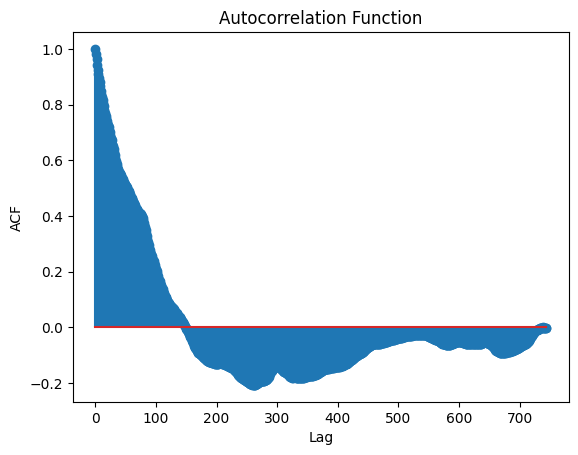

In [5]:
# Tính toán ACF
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data['Price'], nlags= 1000
                           )

# Vẽ đồ thị ACF
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')
plt.show()

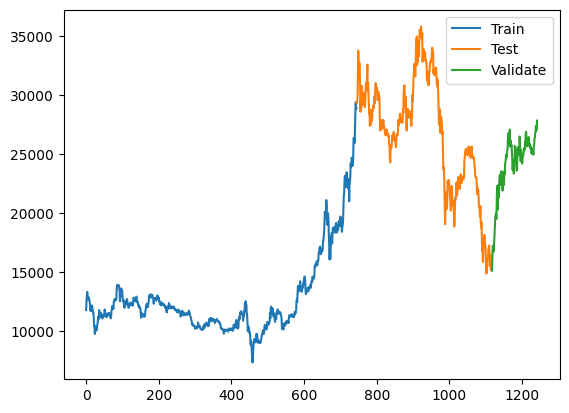

In [6]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index,val_data['Price'])
plt.legend(['Train', 'Test','Validate',])
plt.show()

In [7]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

feature = []
for price in train_data['High']:
  feature.append([price])
print(feature)
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
model = dlm(y_train)
model = model + trend(1, name='lineTrend', w=1.0)
model = model + autoReg(degree=3, data=y_train, name='ar1', w=1e7) + longSeason(period=8, stay=1, data=y_train, name='monthly', w=3.0) + dynamic(features=feature, discount=1, name='High')


[[12000], [12550], [13150], [13450], [13350], [13100], [12900], [12950], [12950], [12800], [12600], [12550], [11950], [12000], [12000], [12050], [12350], [12050], [12200], [11850], [11700], [11550], [11250], [10650], [10350], [10400], [10750], [10600], [10300], [10450], [10500], [10700], [10800], [11200], [11200], [11100], [11750], [11800], [11550], [11350], [11400], [11550], [11700], [11550], [11300], [11300], [11350], [11250], [11350], [11650], [11350], [11800], [11850], [11750], [11400], [11600], [11300], [11300], [11600], [11500], [11450], [11550], [11550], [11550], [11550], [11550], [11400], [11250], [11200], [11500], [11800], [11850], [12300], [12200], [12200], [12050], [12400], [12750], [12650], [12900], [12850], [12800], [12900], [12850], [13500], [14400], [14050], [14050], [13950], [14300], [13950], [13950], [13600], [13100], [13100], [13200], [13600], [13900], [13850], [13600], [13500], [12950], [12850], [12650], [12750], [12350], [12300], [12500], [12600], [12550], [12400], 

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


In [8]:

model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [9]:
# 4. Quá trình testing
x_test= []

for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Price'])
y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'High': x_test})
y_pred = y_pred[0]



(372, 1)


In [10]:

y_val = np.array(val_data['Price'])
x_val= []

for price in val_data['High']:
  x_val.append([price])
print(type(x_val))

size = test_size + val_size
y_pred_val = model.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[15591.916967910522, 20920.79430981627, 18300.74043097058, 20895.460893920022, 19154.95691103012, 20739.123068081215, 19879.860466118746, 20772.2252500938, 21023.357313223743, 21916.954179267563, 21723.190255019377, 22096.79695306854, 22844.802421194407, 22399.52587165785, 24113.79321539264, 23711.01587344202, 22375.812790559547, 23605.49469726501, 23842.532046077933, 23913.43388971232, 23919.89509762375, 24847.05045344794, 24664.375608120656, 24393.5767417903, 24655.241997865825, 23631.49448459739, 25369.715700526976, 24867.10344971476, 24928.91385857752, 24653.68353489703, 24267.665328481584, 24373.04104226793, 24270.00219867308, 24137.536638748516, 25025.08345741764, 25122.994376669998, 25408.093964254276, 26153.23049079574, 25824.49531868112, 26321.325630537074, 26179.361313979338, 25908.180442641464, 26428.878198488084, 26254.219537140114, 27450.781190193527, 27282.113020956862, 27675.996538906842, 27843.22148041028, 27110.694436089554, 27889.13901618616, 27651.2542

In [11]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 1773.7481955789863
Testing RMSE: 2984.135094088976
Validation MAPE: 7.201483796068518
Testing MAPE: 10.457452677600807
Validation MAE: 1665.9577648199845
Testing MAE: 2309.780223639389


In [ ]:
# Dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])


#test
x_test_ln = np.array(test_data.index).reshape(-1, 1)
y_test_ln = np.array(test_data['High'])
y_pred_ln = ln_model.predict(x_test_ln)

# Quá trình Validate
x_val_ln= np.array(val_data.index).reshape(-1, 1)
y_val_ln = np.array(val_data)
y_pred_val_ln =  ln_model.predict(x_val_ln)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = ln_model.predict(feature_next_30_days)

print(feature_next_30_days)






[10242.12978054 10240.67627656 10239.22277258 10237.76926859
 10236.31576461 10234.86226063 10233.40875665 10231.95525267
 10230.50174869 10229.04824471 10227.59474073 10226.14123674
 10224.68773276 10223.23422878 10221.7807248  10220.32722082
 10218.87371684 10217.42021286 10215.96670887 10214.51320489
 10213.05970091 10211.60619693 10210.15269295 10208.69918897
 10207.24568499 10205.79218101 10204.33867702 10202.88517304
 10201.43166906 10199.97816508]


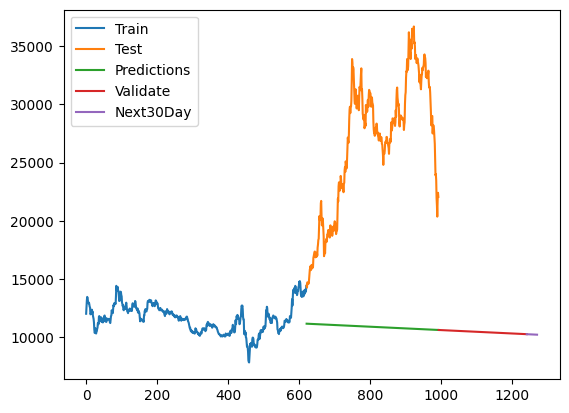

In [ ]:
plt.plot(train_data.index, train_data['High'])
plt.plot(test_data.index, test_data['High'])
plt.plot(test_data.index,y_pred_ln)
plt.plot(val_data.index,y_pred_val_ln)
plt.plot(last_data,feature_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = model.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)


<class 'list'>
2
[10017.708249776542, 11642.32815348998, 10576.459651388728, 11047.397021704584, 10841.426467421277, 10928.71591427, 10852.088295668798, 10902.819032520967, 10910.12433985911, 10901.646449146037, 10955.951592854895, 10858.442464512116, 10982.225077782403, 10890.203246968229, 10914.079103812343, 10909.282358456045, 10947.475274534116, 10921.87104598213, 10985.686721984468, 10882.900037311823, 11009.61225253089, 10915.964444338648, 10940.742814090912, 10935.44513910837, 10973.916095266473, 10948.15754231493, 11012.058875431792, 10909.224647220495, 11035.963251257414, 10942.300796081652]


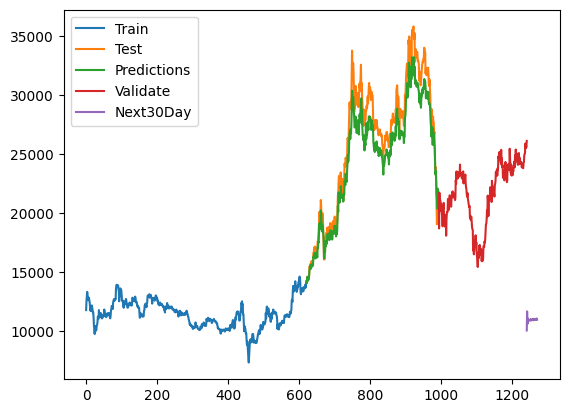

In [ ]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index,y_pred)
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()